In [1]:
%matplotlib inline
import torch
from PIL import Image
import os
import glob
import random
import csv
random.seed(4)
import json
import pandas as pd
import numpy as np
import tqdm

import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
#import albumentations as A
import cv2
from helpers.plotting import *
from helpers.ml_utils import *
## A nettoyer

In [2]:
### Parametrisation ###

model_path = "../saved_models/model_SGD_balanced/model_SGD_balanced"
name_dataset = 'dataset_Trashedy_1.0'
path_to_data = '../dataset/'+ name_dataset + '/valid/'
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cat_to_index = {'other': 1, 
                'pet': 2,
                'plastic_bag' : 3
                }

In [3]:


tensor_transform = transforms.Compose([transforms.ToTensor()])

dataset = ObjectDetectionDataset(path_to_dataset = path_to_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'test')

data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [4]:
model = torch.load(model_path)

In [5]:
results = evaluate(data_loader,device,cat_to_index,model)
print("Fin de l'évaluation")

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]C:\Users\diabo\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:26<00:00,  4.73s/it]

Fin de l'évaluation


28 Images avec 83 objets detectés
Entrer indice de l'image à afficher : 26
Nombre de déchets identifiés :  22


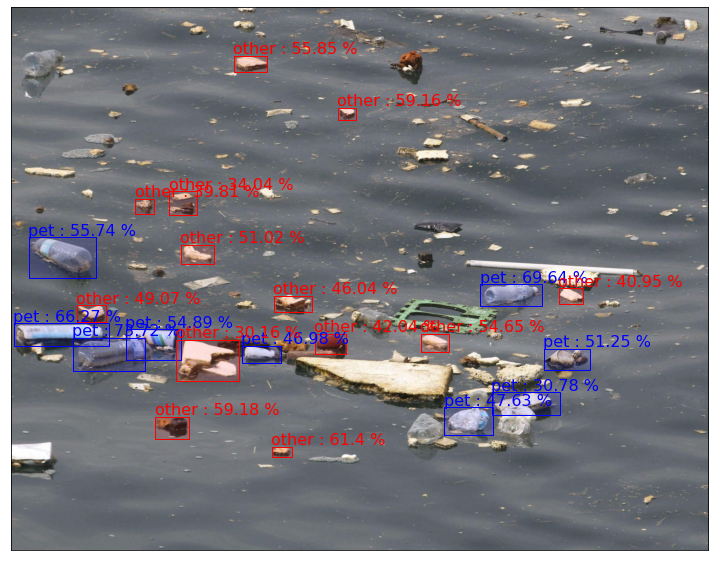

In [12]:
l_file_name = np.unique([row['file_name'] for row in results])
n_file_name = len(l_file_name)
n_objects = len(results)
print("{} Images avec {} objets detectés".format(n_file_name,n_objects))
idx = int(input("Entrer indice de l'image à afficher : "))
color_map = {'other': 'red','pet':'blue','plastic_bag':'orange'}
show_result(results,path_to_data , l_file_name[idx],color_map = color_map)

In [7]:
path_to_data_2 = '../dataset/'+ name_dataset + '/train/'
valid_dataset = ObjectDetectionDataset(path_to_dataset = path_to_data_2,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'valid')

valid_data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)



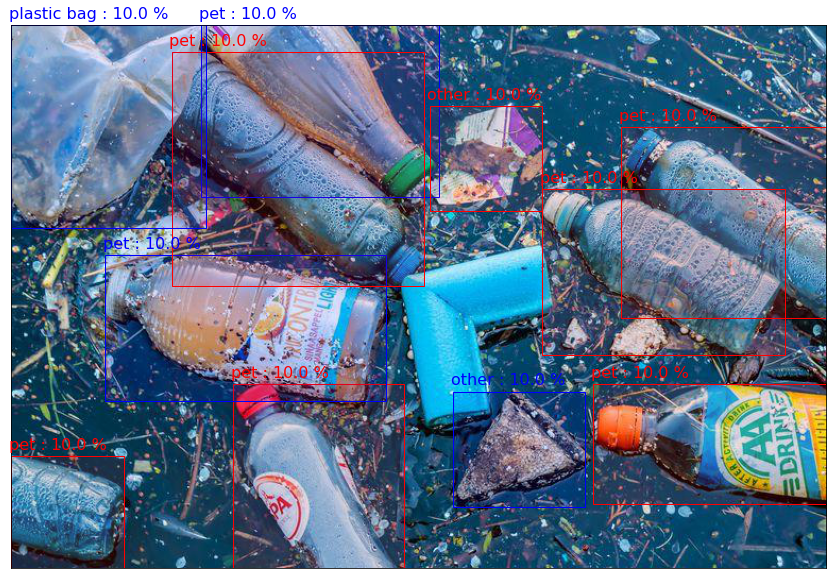

In [8]:
mapping = { value : key for (key, value) in cat_to_index.items()}
cat = ['other','pet','plastic bag']
nbe = 1

targ = valid_dataset.__getitem__(nbe)
img = targ[0].permute(1,2,0)
l_boxes = targ[1]['boxes']
labels = targ[1]['labels']
labels = list(labels.numpy())
labels = [cat[i-1] for i in labels]
scores = [0.1 for i in labels]
show_bounding_boxes(img,l_boxes,labels = labels,l_scores = scores,fontsize = 16)

In [9]:
mapping

{1: 'other', 2: 'pet', 3: 'plastic_bag'}

In [10]:
nbe = 1

targ = valid_dataset.__getitem__(nbe)
img = targ[0].permute(1,2,0)
l_boxes = targ[1]['boxes']

In [11]:
a= list(l_boxes.numpy())
print(a)
b = get_intersection_area(a[5],a[6])
print(b)

[array([209., 338., 370., 512.], dtype=float32), array([  0., 406., 106., 512.], dtype=float32), array([500., 154., 729., 311.], dtype=float32), array([574.,  96., 768., 276.], dtype=float32), array([ 88., 216., 353., 354.], dtype=float32), array([179.,   0., 403., 162.], dtype=float32), array([151.,  25., 389., 246.], dtype=float32), array([548., 338., 768., 451.], dtype=float32), array([  0.,   0., 183., 191.], dtype=float32), array([416., 345., 540., 454.], dtype=float32), array([394.,  76., 500., 175.], dtype=float32)]


NameError: name 'get_intersection_area' is not defined